In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
import numpy as np
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# **Домашнее задание к уроку 6**

### Задание 1

Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [3]:
# Загрузка датасета
X, y = load_diabetes(return_X_y=True)

In [4]:
# Разбиение выборки на обучающую и тестовую
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

In [11]:
# Класс градиентного бустинга
class GradientBoosting:
    
    def __init__(self, n_trees=10, max_depth=3, coefs=None, eta=0.1, model=DecisionTreeRegressor):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.eta = eta
        if coefs is None:
            self.coefs = [1] * n_trees
        else:
            self.coefs = coefs
        self.model = model
        self.trees = []
    
    
    def mean_squared_error(self, y_real, prediction):
        return np.mean((y_real - prediction)**2)
    
    
    def bias(self, y, z):
        return (y - z)
    
   
    def gb_predict(self, X):
        # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
        # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
        return np.sum([self.eta* coef * alg.predict(X) for alg, coef in zip(self.trees, self.coefs)], axis=0)

    def gb_fit(self, X_train, X_test, y_train, y_test):

        # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
        train_errors = []
        test_errors = []

        for i in range(self.n_trees):
            tree = self.model(max_depth=self.max_depth, random_state=42)

            # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
            # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
            if not self.trees:
                # обучаем первое дерево на обучающей выборке
                tree.fit(X_train, y_train)
                target = self.gb_predict(X_train)
                test_target = self.gb_predict(X_test)                
            else:
                # Получим ответы на текущей композиции
                target = self.gb_predict(X_train)
                test_target = self.gb_predict(X_test)

                # алгоритмы начиная со второго обучаем на сдвиг
                tree.fit(X_train, self.bias(y_train, target))

            train_errors.append(self.mean_squared_error(y_train, target))
            test_errors.append(self.mean_squared_error(y_test, test_target))
            self.trees.append(tree)

        return train_errors, test_errors

In [12]:
# Функция для построения графика зависимости ошибки от количества деревьев
def tree_plot(tree_list, max_depth, X_train, X_test, y_train, y_test):
    search_train_errors = []
    search_test_errors = []
    for itm in tree_list:
        gb = GradientBoosting(n_trees=itm, max_depth=max_depth)
        train_errors, test_errors = gb.gb_fit(X_train, X_test, y_train, y_test)
        search_train_errors.append(train_errors[-1])
        search_test_errors.append(test_errors[-1])
    plt.figure(figsize = (16, 7))
    plt.plot(tree_list, search_train_errors, label='train')
    plt.plot(tree_list, search_test_errors, label='test')
    plt.xlabel('n_tree')
    plt.ylabel('MSE')
    plt.grid()
    plt.legend()

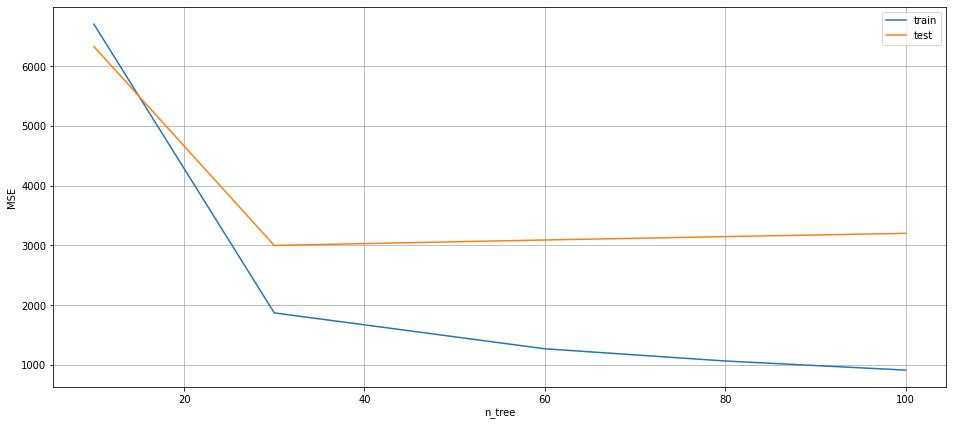

In [14]:
tree_list = [10, 30, 60, 80, 100]
tree_plot(tree_list, 3, X_train, X_test, y_train, y_test)

**Вывод:** График показывает, что примерно при 30 деревьях ошибка минимальна на тесте. После этой точки график начинает возрастать, т.е. начинается переобучение.

In [15]:
# Функция для построения графика зависимости ошибки от максимальной глубины дерева
def max_depth_plot(n_tree, max_depth_list, X_train, X_test, y_train, y_test):
    search_train_errors = []
    search_test_errors = []
    for itm in max_depth_list:
        gb = GradientBoosting(n_trees=n_tree, max_depth=itm)
        train_errors, test_errors = gb.gb_fit(X_train, X_test, y_train, y_test)
        search_train_errors.append(train_errors[-1])
        search_test_errors.append(test_errors[-1])
    plt.figure(figsize = (16, 7))
    plt.plot(max_depth_list, search_train_errors, label='train')
    plt.plot(max_depth_list, search_test_errors, label='test')
    plt.xlabel('max_depth')
    plt.ylabel('MSE')
    plt.grid()
    plt.legend()

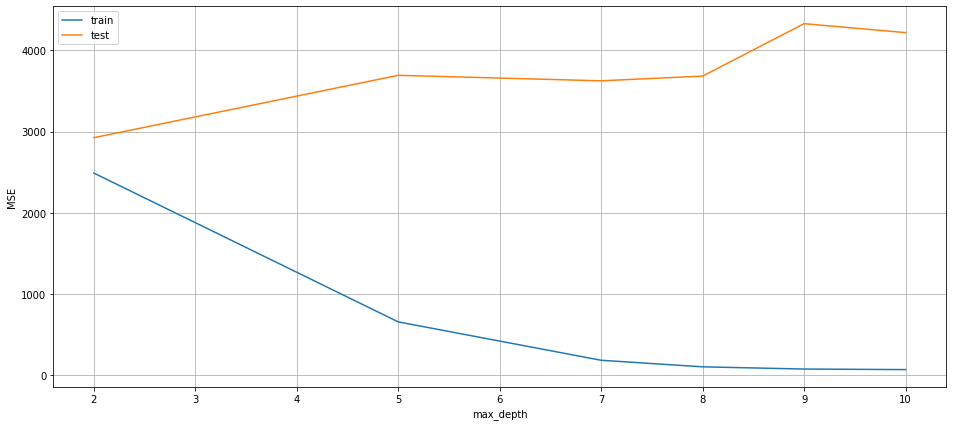

In [16]:
max_depth_list = [2, 5, 7, 8, 9, 10]
max_depth_plot(30, max_depth_list, X_train, X_test, y_train, y_test)

**Вывод:** График показывает, что при максимальной глубине равной 2 ошибка минимальна. Затем трейн и тест сильно расходятся, наблюдается переобучение.